In [1]:
import os
import numpy as np
import bayesflow as bf
import pandas as pd
import pickle
import tensorflow as tf
import priors_and_simulators as ps
import seaborn as sns
import matplotlib.pyplot as plt
from multiprocessing import Pool

# Suppress scientific notation for floats
np.set_printoptions(suppress=True)

# Define settings
PATH = '/home/mischa/Documents/bayesflow/prj_real_life_ddm/data/prepared_data/'
PATH_TO_SAVE = '/home/mischa/Documents/bayesflow/prj_real_life_ddm/data/pickle_model_comparison/'

NUM_ITERATIONS_PER_EPOCH = 10000
BATCH_SIZE = 32
NUM_EPOCHS = 150

model_names = ["DDM", "sv/st0", "Levy", "GSR"]

simple_PARAM_NAMES = [
    r"$v_{congruent}$",
    r"$v_{incongruent}$",
    r"$a_{congruent}$",
    r"$a_{incongruent}$",
    r"$\tau_{correct}$",
    r"$\tau_{error}$"
]

levy_PARAM_NAMES = [
    r"$v_{congruent}$",
    r"$v_{incongruent}$",
    r"$a_{congruent}$",
    r"$a_{incongruent}$",
    r"$\tau_{correct}$",
    r"$\tau_{error}$",
    r"$\alpha$"
]


sv_st0_PARAM_NAMES = [
    r"$v_{congruent}$",
    r"$v_{incongruent}$",
    r"$a_{congruent}$",
    r"$a_{incongruent}$",
    r"$\tau_{correct}$",
    r"$\tau_{error}$",
    r"$s_{tau}$",
    r"$s_{v}$"
]

gsr_PARAM_NAMES = [
    r"$\gamma$",
    r"$v_{word}$",
    r"$v_{picture}$",
    r"$a_{congruent}$",
    r"$a_{incongruent}$",

    r"$\tau_{correct}$",
    r"$\tau_{error}$",
    r"$s_{v}$",
    r"$s_{ndt}"
]

2024-08-07 16:44:22.901747: I tensorflow/core/util/port.cc:110] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-08-07 16:44:22.926731: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-08-07 16:44:23.341760: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
/home/mischa/miniconda3/envs/bf/lib/python3.10/site-packages/bayesflow/trainers.py:27: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook imp

In [2]:
#Load prior functions, simulators

simple_ddm_prior = bf.simulation.Prior(prior_fun=ps.simple_ddm_prior_fun, param_names=simple_PARAM_NAMES)
levy_prior = bf.simulation.Prior(prior_fun=ps.levy_prior_fun, param_names=levy_PARAM_NAMES)
sv_st0_ddm_prior = bf.simulation.Prior(prior_fun=ps.sv_st0_ddm_prior_fun, param_names=sv_st0_PARAM_NAMES)
gsr_ddm_prior = bf.simulation.Prior(prior_fun=ps.gsr_ddm_prior_fun, param_names=gsr_PARAM_NAMES)

simple_ddm_simulator = bf.simulation.Simulator(simulator_fun=ps.simple_ddm_simulator_fun)
sv_st0_ddm_simulator = bf.simulation.Simulator(simulator_fun=ps.sv_st0_ddm_simulator_fun)
levy_simulator = bf.simulation.Simulator(simulator_fun=ps.levy_simulator_fun)
gsr_ddm_simulator = bf.simulation.Simulator(simulator_fun=ps.gsr_ddm_simulator_fun)

In [8]:
#Define generative models

model_simple_ddm = bf.simulation.GenerativeModel(
    prior=simple_ddm_prior,
    simulator=simple_ddm_simulator,
    name="simple_ddm")

model_sv_st0_ddm = bf.simulation.GenerativeModel(
    prior=sv_st0_ddm_prior,
    simulator=sv_st0_ddm_simulator,
    name="sv_st0_ddm")

model_levy= bf.simulation.GenerativeModel(
    prior=levy_prior,
    simulator=levy_simulator,
    name="levy")

model_gsr_ddm = bf.simulation.GenerativeModel(
    prior=gsr_ddm_prior,
    simulator=gsr_ddm_simulator,
    name="GSR_ddm")

generative_models = bf.simulation.MultiGenerativeModel([model_simple_ddm,
                                                        model_sv_st0_ddm,
                                                        model_levy,
                                                       model_gsr_ddm])
                                                          

INFO:root:Performing 2 pilot runs with the simple_ddm model...
INFO:root:Shape of parameter batch after 2 pilot simulations: (batch_size = 2, 6)
INFO:root:Shape of simulation batch after 2 pilot simulations: (batch_size = 2, 120, 4)
INFO:root:No optional prior non-batchable context provided.
INFO:root:No optional prior batchable context provided.
INFO:root:No optional simulation non-batchable context provided.
INFO:root:No optional simulation batchable context provided.
INFO:root:Performing 2 pilot runs with the sv_st0_ddm model...
INFO:root:Shape of parameter batch after 2 pilot simulations: (batch_size = 2, 8)
INFO:root:Shape of simulation batch after 2 pilot simulations: (batch_size = 2, 120, 4)
INFO:root:No optional prior non-batchable context provided.
INFO:root:No optional prior batchable context provided.
INFO:root:No optional simulation non-batchable context provided.
INFO:root:No optional simulation batchable context provided.
INFO:root:Performing 2 pilot runs with the levy mo

In [15]:
#Define networks, amortizer, trainer

summary_net = bf.summary_networks.SetTransformer(input_dim=4)

inference_net = bf.inference_networks.PMPNetwork(num_models=4, dropout=False)

amortizer = bf.amortizers.AmortizedModelComparison(inference_net, summary_net)

trainer = bf.trainers.Trainer(
    amortizer=amortizer,
    generative_model=generative_models,
    checkpoint_path = "model_comparison_checks"
)

INFO:root:Initialized empty loss history.
INFO:root:Initialized networks from scratch.
INFO:root:Performing a consistency check with provided components...
INFO:root:Done.


# Train model comparison network

In [7]:
# Pre-simulate data for offline training (much faster due to parallel processing)        
#if __name__ == '__main__':
#    with Pool(processes=30) as pool:       
#        pool.map(ps.presimulator, range(NUM_EPOCHS))

In [16]:
optimizer = tf.keras.optimizers.Adam(learning_rate=
                                     tf.keras.optimizers.schedules.CosineDecay(
                                         0.00025, NUM_ITERATIONS_PER_EPOCH*NUM_EPOCHS, alpha=0.0, name=None))
losses = trainer.train_from_presimulation('model_comparison_sims', optimizer = optimizer,
                                         reuse_optimizer=True)

Training epoch 1:   0%|          | 0/10000 [00:00<?, ?it/s]

Training epoch 2:   0%|          | 0/10000 [00:00<?, ?it/s]

Training epoch 3:   0%|          | 0/10000 [00:00<?, ?it/s]

Training epoch 4:   0%|          | 0/10000 [00:00<?, ?it/s]

Training epoch 5:   0%|          | 0/10000 [00:00<?, ?it/s]

Training epoch 6:   0%|          | 0/10000 [00:00<?, ?it/s]

Training epoch 7:   0%|          | 0/10000 [00:00<?, ?it/s]

Training epoch 8:   0%|          | 0/10000 [00:00<?, ?it/s]

Training epoch 9:   0%|          | 0/10000 [00:00<?, ?it/s]

Training epoch 10:   0%|          | 0/10000 [00:00<?, ?it/s]

Training epoch 11:   0%|          | 0/10000 [00:00<?, ?it/s]

Training epoch 12:   0%|          | 0/10000 [00:00<?, ?it/s]

Training epoch 13:   0%|          | 0/10000 [00:00<?, ?it/s]

Training epoch 14:   0%|          | 0/10000 [00:00<?, ?it/s]

Training epoch 15:   0%|          | 0/10000 [00:00<?, ?it/s]

Training epoch 16:   0%|          | 0/10000 [00:00<?, ?it/s]

Training epoch 17:   0%|          | 0/10000 [00:00<?, ?it/s]

Training epoch 18:   0%|          | 0/10000 [00:00<?, ?it/s]

Training epoch 19:   0%|          | 0/10000 [00:00<?, ?it/s]

Training epoch 20:   0%|          | 0/10000 [00:00<?, ?it/s]

Training epoch 21:   0%|          | 0/10000 [00:00<?, ?it/s]

Training epoch 22:   0%|          | 0/10000 [00:00<?, ?it/s]

Training epoch 23:   0%|          | 0/10000 [00:00<?, ?it/s]

Training epoch 24:   0%|          | 0/10000 [00:00<?, ?it/s]

Training epoch 25:   0%|          | 0/10000 [00:00<?, ?it/s]

Training epoch 26:   0%|          | 0/10000 [00:00<?, ?it/s]

Training epoch 27:   0%|          | 0/10000 [00:00<?, ?it/s]

Training epoch 28:   0%|          | 0/10000 [00:00<?, ?it/s]

Training epoch 29:   0%|          | 0/10000 [00:00<?, ?it/s]

Training epoch 30:   0%|          | 0/10000 [00:00<?, ?it/s]

Training epoch 31:   0%|          | 0/10000 [00:00<?, ?it/s]

Training epoch 32:   0%|          | 0/10000 [00:00<?, ?it/s]

Training epoch 33:   0%|          | 0/10000 [00:00<?, ?it/s]

Training epoch 34:   0%|          | 0/10000 [00:00<?, ?it/s]

Training epoch 35:   0%|          | 0/10000 [00:00<?, ?it/s]

Training epoch 36:   0%|          | 0/10000 [00:00<?, ?it/s]

Training epoch 37:   0%|          | 0/10000 [00:00<?, ?it/s]

Training epoch 38:   0%|          | 0/10000 [00:00<?, ?it/s]

Training epoch 39:   0%|          | 0/10000 [00:00<?, ?it/s]

Training epoch 40:   0%|          | 0/10000 [00:00<?, ?it/s]

Training epoch 41:   0%|          | 0/10000 [00:00<?, ?it/s]

Training epoch 42:   0%|          | 0/10000 [00:00<?, ?it/s]

Training epoch 43:   0%|          | 0/10000 [00:00<?, ?it/s]

Training epoch 44:   0%|          | 0/10000 [00:00<?, ?it/s]

Training epoch 45:   0%|          | 0/10000 [00:00<?, ?it/s]

Training epoch 46:   0%|          | 0/10000 [00:00<?, ?it/s]

Training epoch 47:   0%|          | 0/10000 [00:00<?, ?it/s]

Training epoch 48:   0%|          | 0/10000 [00:00<?, ?it/s]

Training epoch 49:   0%|          | 0/10000 [00:00<?, ?it/s]

Training epoch 50:   0%|          | 0/10000 [00:00<?, ?it/s]

Training epoch 51:   0%|          | 0/10000 [00:00<?, ?it/s]

Training epoch 52:   0%|          | 0/10000 [00:00<?, ?it/s]

Training epoch 53:   0%|          | 0/10000 [00:00<?, ?it/s]

Training epoch 54:   0%|          | 0/10000 [00:00<?, ?it/s]

Training epoch 55:   0%|          | 0/10000 [00:00<?, ?it/s]

Training epoch 56:   0%|          | 0/10000 [00:00<?, ?it/s]

Training epoch 57:   0%|          | 0/10000 [00:00<?, ?it/s]

Training epoch 58:   0%|          | 0/10000 [00:00<?, ?it/s]

Training epoch 59:   0%|          | 0/10000 [00:00<?, ?it/s]

Training epoch 60:   0%|          | 0/10000 [00:00<?, ?it/s]

Training epoch 61:   0%|          | 0/10000 [00:00<?, ?it/s]

Training epoch 62:   0%|          | 0/10000 [00:00<?, ?it/s]

Training epoch 63:   0%|          | 0/10000 [00:00<?, ?it/s]

Training epoch 64:   0%|          | 0/10000 [00:00<?, ?it/s]

Training epoch 65:   0%|          | 0/10000 [00:00<?, ?it/s]

Training epoch 66:   0%|          | 0/10000 [00:00<?, ?it/s]

Training epoch 67:   0%|          | 0/10000 [00:00<?, ?it/s]

Training epoch 68:   0%|          | 0/10000 [00:00<?, ?it/s]

Training epoch 69:   0%|          | 0/10000 [00:00<?, ?it/s]

Training epoch 70:   0%|          | 0/10000 [00:00<?, ?it/s]

Training epoch 71:   0%|          | 0/10000 [00:00<?, ?it/s]

Training epoch 72:   0%|          | 0/10000 [00:00<?, ?it/s]

Training epoch 73:   0%|          | 0/10000 [00:00<?, ?it/s]

Training epoch 74:   0%|          | 0/10000 [00:00<?, ?it/s]

Training epoch 75:   0%|          | 0/10000 [00:00<?, ?it/s]

Training epoch 76:   0%|          | 0/10000 [00:00<?, ?it/s]

Training epoch 77:   0%|          | 0/10000 [00:00<?, ?it/s]

Training epoch 78:   0%|          | 0/10000 [00:00<?, ?it/s]

Training epoch 79:   0%|          | 0/10000 [00:00<?, ?it/s]

Training epoch 80:   0%|          | 0/10000 [00:00<?, ?it/s]

Training epoch 81:   0%|          | 0/10000 [00:00<?, ?it/s]

Training epoch 82:   0%|          | 0/10000 [00:00<?, ?it/s]

Training epoch 83:   0%|          | 0/10000 [00:00<?, ?it/s]

Training epoch 84:   0%|          | 0/10000 [00:00<?, ?it/s]

Training epoch 85:   0%|          | 0/10000 [00:00<?, ?it/s]

Training epoch 86:   0%|          | 0/10000 [00:00<?, ?it/s]

Training epoch 87:   0%|          | 0/10000 [00:00<?, ?it/s]

Training epoch 88:   0%|          | 0/10000 [00:00<?, ?it/s]

Training epoch 89:   0%|          | 0/10000 [00:00<?, ?it/s]

Training epoch 90:   0%|          | 0/10000 [00:00<?, ?it/s]

Training epoch 91:   0%|          | 0/10000 [00:00<?, ?it/s]

Training epoch 92:   0%|          | 0/10000 [00:00<?, ?it/s]

Training epoch 93:   0%|          | 0/10000 [00:00<?, ?it/s]

Training epoch 94:   0%|          | 0/10000 [00:00<?, ?it/s]

Training epoch 95:   0%|          | 0/10000 [00:00<?, ?it/s]

Training epoch 96:   0%|          | 0/10000 [00:00<?, ?it/s]

Training epoch 97:   0%|          | 0/10000 [00:00<?, ?it/s]

Training epoch 98:   0%|          | 0/10000 [00:00<?, ?it/s]

Training epoch 99:   0%|          | 0/10000 [00:00<?, ?it/s]

Training epoch 100:   0%|          | 0/10000 [00:00<?, ?it/s]

Training epoch 101:   0%|          | 0/10000 [00:00<?, ?it/s]

Training epoch 102:   0%|          | 0/10000 [00:00<?, ?it/s]

Training epoch 103:   0%|          | 0/10000 [00:00<?, ?it/s]

Training epoch 104:   0%|          | 0/10000 [00:00<?, ?it/s]

Training epoch 105:   0%|          | 0/10000 [00:00<?, ?it/s]

Training epoch 106:   0%|          | 0/10000 [00:00<?, ?it/s]

Training epoch 107:   0%|          | 0/10000 [00:00<?, ?it/s]

Training epoch 108:   0%|          | 0/10000 [00:00<?, ?it/s]

Training epoch 109:   0%|          | 0/10000 [00:00<?, ?it/s]

Training epoch 110:   0%|          | 0/10000 [00:00<?, ?it/s]

Training epoch 111:   0%|          | 0/10000 [00:00<?, ?it/s]

Training epoch 112:   0%|          | 0/10000 [00:00<?, ?it/s]

Training epoch 113:   0%|          | 0/10000 [00:00<?, ?it/s]

Training epoch 114:   0%|          | 0/10000 [00:00<?, ?it/s]

Training epoch 115:   0%|          | 0/10000 [00:00<?, ?it/s]

Training epoch 116:   0%|          | 0/10000 [00:00<?, ?it/s]

Training epoch 117:   0%|          | 0/10000 [00:00<?, ?it/s]

Training epoch 118:   0%|          | 0/10000 [00:00<?, ?it/s]

Training epoch 119:   0%|          | 0/10000 [00:00<?, ?it/s]

Training epoch 120:   0%|          | 0/10000 [00:00<?, ?it/s]

Training epoch 121:   0%|          | 0/10000 [00:00<?, ?it/s]

Training epoch 122:   0%|          | 0/10000 [00:00<?, ?it/s]

Training epoch 123:   0%|          | 0/10000 [00:00<?, ?it/s]

Training epoch 124:   0%|          | 0/10000 [00:00<?, ?it/s]

Training epoch 125:   0%|          | 0/10000 [00:00<?, ?it/s]

Training epoch 126:   0%|          | 0/10000 [00:00<?, ?it/s]

Training epoch 127:   0%|          | 0/10000 [00:00<?, ?it/s]

Training epoch 128:   0%|          | 0/10000 [00:00<?, ?it/s]

Training epoch 129:   0%|          | 0/10000 [00:00<?, ?it/s]

Training epoch 130:   0%|          | 0/10000 [00:00<?, ?it/s]

Training epoch 131:   0%|          | 0/10000 [00:00<?, ?it/s]

Training epoch 132:   0%|          | 0/10000 [00:00<?, ?it/s]

Training epoch 133:   0%|          | 0/10000 [00:00<?, ?it/s]

Training epoch 134:   0%|          | 0/10000 [00:00<?, ?it/s]

Training epoch 135:   0%|          | 0/10000 [00:00<?, ?it/s]

Training epoch 136:   0%|          | 0/10000 [00:00<?, ?it/s]

Training epoch 137:   0%|          | 0/10000 [00:00<?, ?it/s]

Training epoch 138:   0%|          | 0/10000 [00:00<?, ?it/s]

Training epoch 139:   0%|          | 0/10000 [00:00<?, ?it/s]

Training epoch 140:   0%|          | 0/10000 [00:00<?, ?it/s]

Training epoch 141:   0%|          | 0/10000 [00:00<?, ?it/s]

Training epoch 142:   0%|          | 0/10000 [00:00<?, ?it/s]

Training epoch 143:   0%|          | 0/10000 [00:00<?, ?it/s]

Training epoch 144:   0%|          | 0/10000 [00:00<?, ?it/s]

Training epoch 145:   0%|          | 0/10000 [00:00<?, ?it/s]

Training epoch 146:   0%|          | 0/10000 [00:00<?, ?it/s]

Training epoch 147:   0%|          | 0/10000 [00:00<?, ?it/s]

Training epoch 148:   0%|          | 0/10000 [00:00<?, ?it/s]

Training epoch 149:   0%|          | 0/10000 [00:00<?, ?it/s]

Training epoch 150:   0%|          | 0/10000 [00:00<?, ?it/s]

# Diagnostics

In [17]:
# Generate 10000 validation data sets
sim_data = generative_models(10000)

# Use the configurator to transform the data structure
sim_data_transformed = trainer.configurator(sim_data)

# Get true indices and predicted PMPs from the trained network
sim_indices = sim_data_transformed["model_indices"]
sim_preds = amortizer(sim_data_transformed)

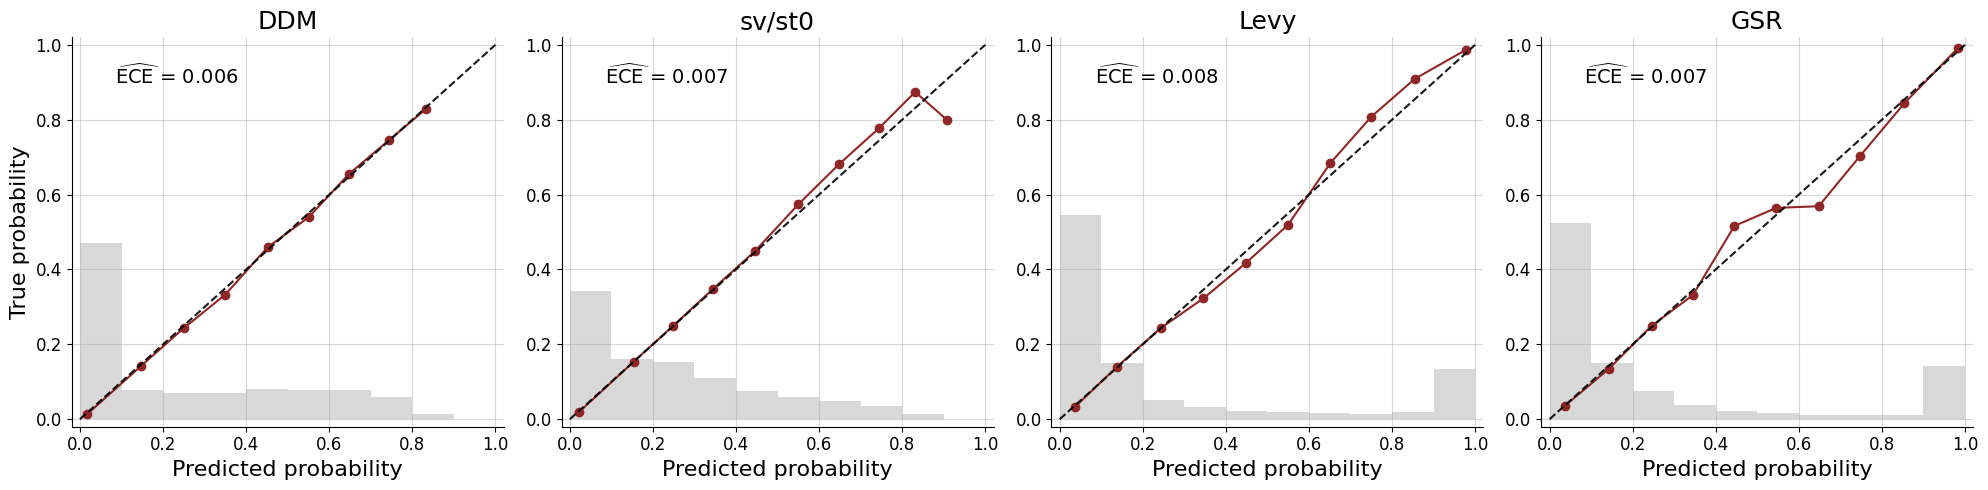

In [20]:
cal_curves = bf.diagnostics.plot_calibration_curves(true_models=sim_indices, pred_models=sim_preds,
                                                   model_names = model_names)

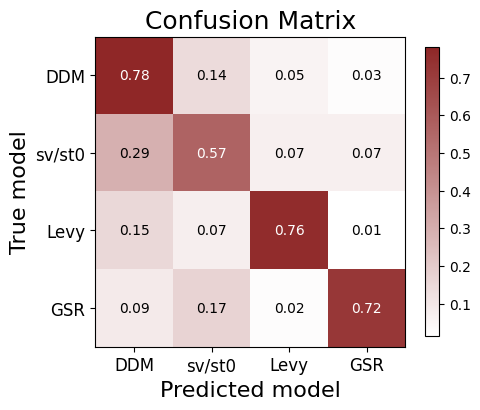

In [21]:
conf_matrix = bf.diagnostics.plot_confusion_matrix(true_models=sim_indices, pred_models=sim_preds,
                                                   model_names = model_names)

# Apply model comparison to Project Implicit data

[0.05620413 0.35988258 0.23320779 0.3507055 ]prepared_False2003iat.p
[0.05696606 0.3675634  0.22894117 0.34652937]prepared_False2004iat.p
[0.06059157 0.39132294 0.21362229 0.3344632 ]prepared_False2005iat.p
[0.06170231 0.40493197 0.2046067  0.32875903]prepared_False2005iat2.p
[0.06191193 0.41340215 0.19754445 0.32714147]prepared_False2005iat3.p
[0.06316453 0.41762214 0.19721171 0.32200162]prepared_False2005iat4.p
[0.06387197 0.42009462 0.19830787 0.31772554]prepared_False2005iat5.p
[0.06394377 0.42013095 0.19821662 0.31770865]prepared_False2005iat6.p
[0.06455501 0.42085277 0.19801268 0.31657954]prepared_False2006iat.p
[0.06465463 0.42364875 0.19830385 0.31339278]prepared_False2006iat2.p
[0.06450021 0.42579523 0.19858763 0.31111693]prepared_False2006iat3.p
[0.06448164 0.42775824 0.19924377 0.30851635]prepared_False2006iat4.p
[0.06501256 0.42953251 0.19864146 0.30681347]prepared_False2006iat5.p
[0.06581962 0.43262327 0.19418372 0.30737338]prepared_False2006iat6.p
[0.06594696 0.43459425 0

[0.06401922 0.44093986 0.19470851 0.30033241]prepared_False2018iat8.p
[0.06401103 0.44099138 0.19450457 0.30049302]prepared_False2018iat9.p
[0.06403141 0.4410545  0.19426097 0.30065312]prepared_False2019iat.p
[0.06401876 0.44114818 0.19400252 0.30083054]prepared_False2019iat10.p
[0.06400494 0.44124769 0.19377262 0.30097476]prepared_False2019iat11.p
[0.06397884 0.44134933 0.19353381 0.30113802]prepared_False2019iat12.p
[0.06396144 0.44142236 0.19333595 0.30128025]prepared_False2019iat13.p
[0.06396341 0.44147906 0.19313097 0.30142656]prepared_False2019iat2.p
[0.06395527 0.4415225  0.19293073 0.30159149]prepared_False2019iat3.p
[0.06395542 0.44161107 0.19272721 0.3017063 ]prepared_False2019iat4.p
[0.06394414 0.44168305 0.192527   0.30184581]prepared_False2019iat5.p
[0.06395765 0.44175794 0.19224443 0.30203997]prepared_False2019iat6.p
[0.06400054 0.44181597 0.19195513 0.30222836]prepared_False2019iat7.p
[0.06402545 0.44183265 0.19177666 0.30236525]prepared_False2019iat8.p
[0.06402643 0.441

[0.06462539 0.44543617 0.1777442  0.31219424]prepared_True2018iat10.p
[0.0646233  0.4454332  0.17765826 0.31228523]prepared_True2018iat11.p
[0.06461738 0.4454272  0.17759456 0.31236086]prepared_True2018iat12.p
[0.06462189 0.44542403 0.17756479 0.31238929]prepared_True2018iat13.p
[0.06461891 0.44540675 0.17750494 0.31246939]prepared_True2018iat2.p
[0.06462089 0.44538816 0.17743409 0.31255685]prepared_True2018iat3.p
[0.06462383 0.44536761 0.17738107 0.3126275 ]prepared_True2018iat4.p
[0.06462721 0.44535759 0.1773078  0.31270741]prepared_True2018iat5.p
[0.06464599 0.445362   0.17719192 0.31280009]prepared_True2018iat6.p
[0.06467494 0.44534175 0.17708204 0.31290127]prepared_True2018iat7.p
[0.06468851 0.44531759 0.17701925 0.31297465]prepared_True2018iat8.p
[0.06469175 0.44531589 0.17696336 0.31302901]prepared_True2018iat9.p
[0.06470783 0.44531785 0.17686471 0.31310961]prepared_True2019iat.p
[0.06470798 0.44533844 0.17677382 0.31317977]prepared_True2019iat10.p
[0.06470335 0.44534988 0.17669

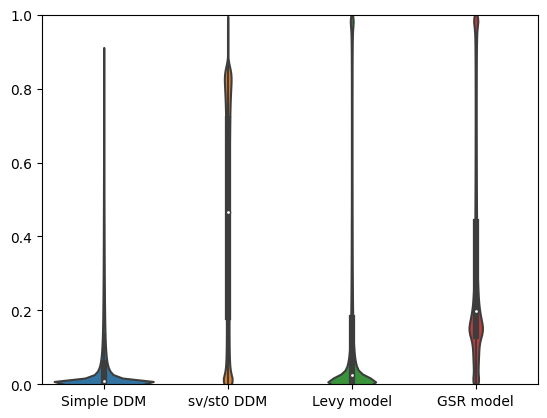

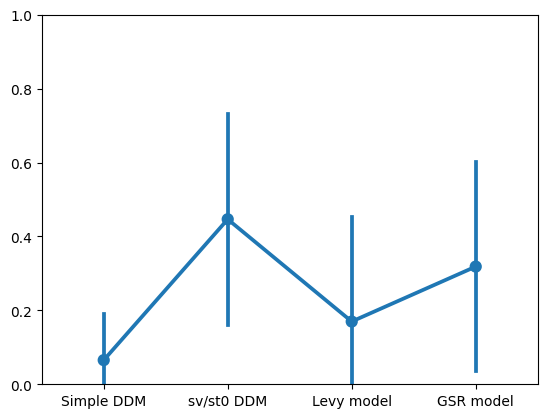

In [36]:
# 1. Create list of all data subsets/chunks, initialize np.array to be filled during inference

datasets = sorted(os.listdir(PATH))

all_probs_and_ids = np.empty((1,6))

# 2. For each chunk

   
for dataset_name in datasets:
    
        # 2.1 Load chunk
        loaded_pickle = pickle.load(open(PATH +str(dataset_name), "rb" ))
        
        X_test = loaded_pickle['data_array']
        y_test = loaded_pickle['outcome_array']

        # 2.2 Estimate chunk
        
        model_probs = np.concatenate([
            amortizer.posterior_probs({"summary_conditions": x}) for x in np.array_split(X_test, 50)], axis=0)
        
        probs_and_ids = np.concatenate([model_probs, y_test], axis=1)  
        
        all_probs_and_ids =  np.concatenate([all_probs_and_ids, probs_and_ids], axis=0)

        print(str(np.mean(all_probs_and_ids[1:,0:4] ,axis=0)) + str(dataset_name))
               
# 3. Save all model probabilites in csv and create figures

df = pd.DataFrame(all_probs_and_ids[1:,:])

df.to_csv("all_model_probabilites.csv")

ax = sns.violinplot(data=all_probs_and_ids[1:,0:4])
ax.set_xticklabels(['Simple DDM','sv/st0 DDM', 'Levy model', 'GSR model'])
ax.set(ylim=(0, 1))
fig = ax.get_figure()
fig.savefig('model_probs.png')    

fig, ax = plt.subplots()
sns.pointplot(df[["0", "1", "2", "3"]], estimator = np.mean, errorbar=("pi", 90))
ax.set_xticklabels(['Simple DDM','sv/st0 DDM', 'Levy model', 'GSR model'])
ax.set_ylim(0, 1)
fig = ax.get_figure()
fig.savefig('model_probs2.png')  

In [41]:
# Simple DDM is best for this number of people:

np.sum((df[0]>df[1])& (df[0]>df[2])& (df[0]>df[3]))

251806

In [42]:
# st0/sv DDM is best for this number of people:

np.sum((df[1]>df[0])& (df[1]>df[2])& (df[1]>df[3]))

3003284

In [43]:
# Levy model is best for this number of people:

np.sum((df[2]>df[0])& (df[2]>df[1])& (df[2]>df[3]))

920357

In [44]:
# GSR model is best for this number of people:

np.sum((df[3]>df[0])& (df[3]>df[1])& (df[3]>df[2]))

1363588

In [2]:
df = pd.read_csv("all_model_probabilites.csv")

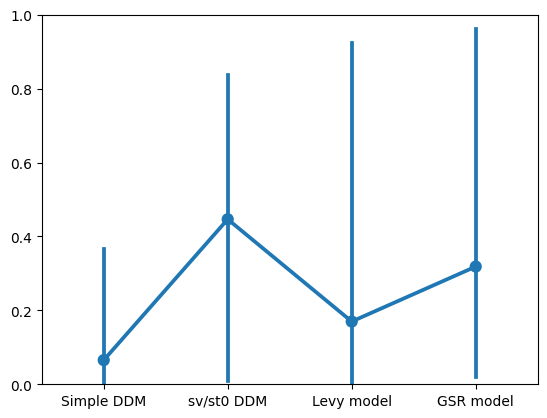